# COGS 108 - EDA Checkpoint

# Names

- Baoni Li
- Huiyi He
- Jiayi Zhu
- Yuhan Zhou
- Yihuan Wang

<a id='research_question'></a>
# Research Question

What factors are associated with higher medical expenditure in adults in the United States? Specifically, are there relationships between medical costs and demographic factors such as age, working hours, and BMI, as well as health-related behaviors such as smoking behavior and overall lifestyle choices? If there are statistically significant relationships between these features and medical expenditure, are they positively or negatively associated?

# Setup

In [1]:
import pandas as pd
import numpy as np
import os

# pip install the following before import
import pyreadstat as pyreadstat
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

# Data Cleaning

The original Dataframe has over 100,000 observations and 1000 columns, yet we only need less than 20 variables, so large amount of data cleaning has to be done, we first cut down the number of columns in the dataframe, merging serveral columns as needed. Then for the purpose of regression, we create dummy variables regarding region, smoking habits, and race. At last, we dropped rows that contains outliers for our numerical variables (age, hours worked, medical expenditure, Body Mass Index)

First, we are cleaned the dataframe, keeping all the columns we need.

In [2]:
# # Read each dta file and store them in a list of dataframes
# path = r'C:\Users\jojo1\OneDrive\Documents\UCSD\UCSD WI23\COGS 108\project'
# files_dta = [file for file in os.listdir(path) if file.endswith('.dta')]

# dfs = pd.DataFrame()
# yrlst = np.arange(11,21,1)
# for i in range(len(files_dta)):
#     filepath = os.path.join(path, files_dta[i])
#     df, meta = pyreadstat.read_dta(filepath)
#     df['YEAR'] = np.repeat(yrlst[i], df.shape[0])
#     df = df.rename(columns={col: col.replace(str(yrlst[i]), '_FINAL') for col in df.columns if str(yrlst[i]) in col})
#     dfs = pd.concat([dfs, df])

# dfs2 = dfs[['OFTSMK53', 'ADSMOK42', 'ADBMI42', 'BMINDX53', 'HOUR31', 
#             'HOUR42', 'HOUR53', 'AGE_FINALX', 
#             'RACEWX', 'RACEBX', 'RACEAX', 'RACETHNX', 'RACETHX',
#             'REGION53', 'REGION42', 'REGION31', 'REGION_FINAL', 
#             'YEAR', 'TOTEXP_FINAL']]

# dfs2 = dfs2.reset_index()
# dfs2 = dfs2.rename(columns={'index' : 'index_within_yr'})

# # Clean region columns 
# def drop_null_regions(df):
#     slice1 = df[df['REGION_FINAL'] == -1].copy()
#     slice2 = slice1[slice1['REGION53'] == -1].copy()
#     slice3 = slice2[slice2['REGION42'] == -1].copy()
#     slice4 = slice3[slice3['REGION31'] == -1].copy()

#     if slice4.shape[0] == 0:
#         None
#     else:
#         df.drop(index=[slice4.index])

# # merging regions
# def merge_region(row):
#     if row['REGION_FINAL'] == -1:
#         if row['REGION53'] == -1:
#             if row['REGION42'] == -1:
#                 return f"{row['REGION31']}"
#             else:
#                 return f"{row['REGION42']}"
#         else:
#             return f"{row['REGION53']}"
#     else:
#         return f"{row['REGION_FINAL']}"

    
# dfs2['REGION_Merged'] = dfs2.apply(merge_region, axis=1)
# dfs2.drop(columns=['REGION_FINAL', 'REGION53', 'REGION42', 'REGION31'])

# """ since it take too long to run the above codes, we are going to export the 
# half cleaned dataset(dfs2) to our repo, so that we won't waste too much time 
# running the above code each time we restart the kernel
# """
# dfs2.to_stata('mydata.dta')

More cleaning 

In [3]:

df = pd.read_stata('mydata.dta')
df = df.fillna(0)
df = df.drop(columns=['REGION_FINAL', 'REGION53', 'REGION42', 'REGION31'])
# Drop BMI
bmi_df = df.get(['ADBMI42', 'BMINDX53'])
df = df[(bmi_df > 0).any(axis=1)]
df['BMI_Merged'] = bmi_df.apply(lambda frame: (frame['ADBMI42'] 
                                + frame['BMINDX53'])/2 if (frame['ADBMI42'] 
                                > 0 and frame['BMINDX53'] > 0) else max(frame['ADBMI42'], frame['BMINDX53']), axis=1)
df.get(['BMI_Merged'])
df = df.drop(columns = ['ADBMI42', 'BMINDX53'])
# Drop Smoking
smoke_df = df.get(['OFTSMK53', 'ADSMOK42'])
df = df[(smoke_df > 0).any(axis=1)]
df['SMOKE_Merged'] = smoke_df.apply(lambda frame: (frame['OFTSMK53'] 
                                + frame['ADSMOK42'])/2 if (frame['OFTSMK53'] 
                                > 0 and frame['ADSMOK42'] > 0) else max(frame['OFTSMK53'], frame['ADSMOK42']), axis=1)
df.get(['SMOKE_Merged'])
df = df.drop(columns = ['OFTSMK53', 'ADSMOK42'])
df = df[df['AGE_FINALX'] >= 21.0]
hour=df[['HOUR31','HOUR42','HOUR53']]
hour = hour.applymap(lambda x: np.nan if x <= 0 else x)
hour = hour.dropna(how='all')
hour['num_notna']=hour.notna().sum(axis=1)
hour=hour.fillna(0)
hour['sum']=hour['HOUR31']+hour['HOUR42']+hour['HOUR53']
hour['HOUR_Merged']=hour['sum']/hour['num_notna']
hour=hour['HOUR_Merged']
final=df.merge(hour,how='right',right_index=True,left_index=True)
final=final.drop(columns=['HOUR31','HOUR42','HOUR53','index','index_within_yr']).reset_index()
final=final.drop(columns='index')
# merge race
final.loc[final['RACETHX'] == 0, 'RACETHX'] = final['RACETHNX']
final = final.drop(columns=['RACETHNX'])
# adjust for inflation in total expenditure
# the inflation rate is acquired from:
# https://www.aier.org/cost-of-living-calculator/
inflation = pd.DataFrame({'year': np.arange(11,21,1),
                          'value': [100, 102.07, 103.56, 105.24, 105.37, 
                                    106.70, 108.97, 111.63, 113.66, 115.06]})
for i in np.arange(11,21,1):
    final.loc[final['YEAR'] == i, 'TOTEXP_FINAL'] = final['TOTEXP_FINAL'] / inflation.value[i - 11] * 100

final['TOTEXP_FINAL'] = final['TOTEXP_FINAL'].round(2)
final = final[['TOTEXP_FINAL', 'AGE_FINALX', 'RACEWX', 'RACEBX', 'RACEAX', 'RACETHX', 'YEAR', 'REGION_Merged', 
               'BMI_Merged', 'SMOKE_Merged', 'HOUR_Merged']]
# final.head()

The above dataframe illustrates all the information we need. Next, since we are planning on runing the data with a multivariate linear regression model, we will clean the data more to make it suitable for a regression.

Creating dummy variables

In [4]:
# Further manipulation data for regression
# Change race variables to dummy variables
final.loc[final['RACEWX'] != 3, 'RACEWX'] = 1
final.loc[final['RACEWX'] == 3, 'RACEWX'] = 0
final.loc[final['RACEAX'] != 3, 'RACEAX'] = 1
final.loc[final['RACEAX'] == 3, 'RACEAX'] = 0
final.loc[final['RACEBX'] != 3, 'RACEBX'] = 1
final.loc[final['RACEBX'] == 3, 'RACEBX'] = 0
final.loc[final['RACETHX'] != 1, 'RACETHX'] = 0

# Change region variables to dummy variables
final['REGION_NORTHEAST'] = 0
final['REGION_MIDEAST'] = 0
final['REGION_SOUTH'] = 0
final.loc[final['REGION_Merged'] == str(1.0), 'REGION_NORTHEAST'] = 1
final.loc[final['REGION_Merged'] == str(2.0), 'REGION_MIDEAST'] = 1
final.loc[final['REGION_Merged'] == str(3.0), 'REGION_SOUTH'] = 1

# Change smoke variables to dummy
final['SMOKE'] = 0
final.loc[final['SMOKE_Merged'] != 3.0, 'SMOKE'] = 1

Dropping outliers, we are going visualize the statistical properties of select columns and decided on the method to use for dropping outliers.

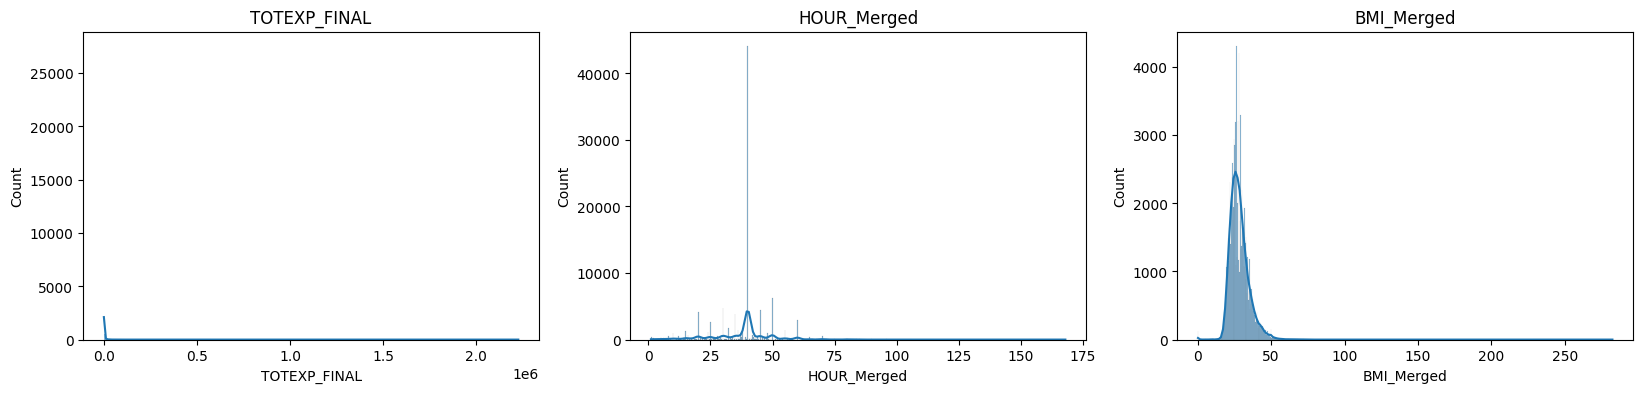

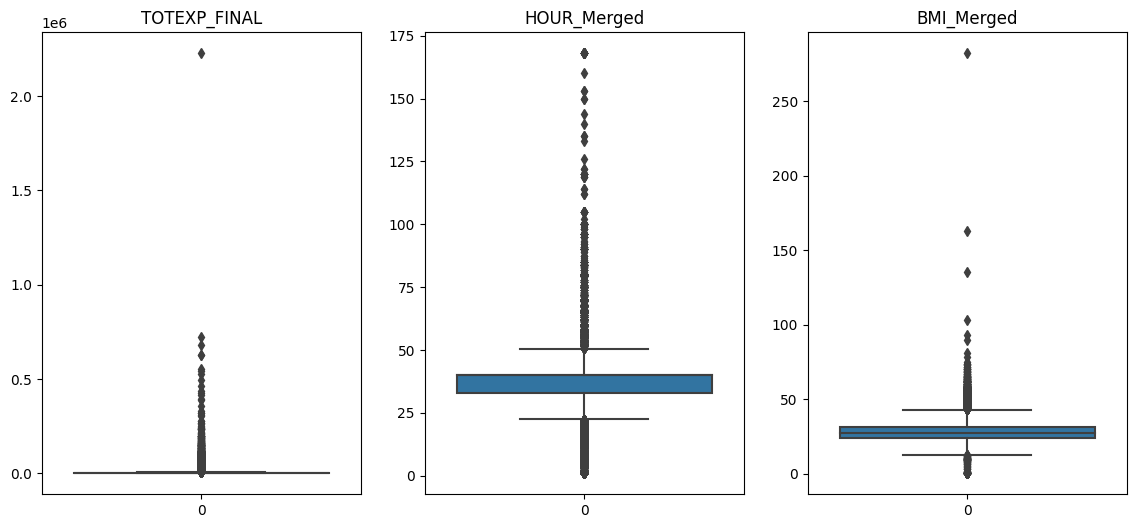

In [5]:
# Dropping outliers
# See distribution in boxplot to determine cutoff for outliers
f1, ax1 = plt.subplots(1, 3, figsize=(20, 4))
sns.histplot(final.TOTEXP_FINAL, kde=True, ax=ax1[0])
ax1[0].set_title('TOTEXP_FINAL')
sns.histplot(final.HOUR_Merged, kde=True, ax=ax1[1])
ax1[1].set_title('HOUR_Merged')
sns.histplot(final.BMI_Merged, kde=True, ax=ax1[2])
ax1[2].set_title('BMI_Merged')
plt.show()

f2, ax2 = plt.subplots(1, 3, figsize=(14, 6))
sns.boxplot(final.TOTEXP_FINAL, ax=ax2[0])
sns.boxplot(final.HOUR_Merged, ax=ax2[1])
sns.boxplot(final.BMI_Merged, ax=ax2[2])
ax2[0].set_title('TOTEXP_FINAL')
ax2[1].set_title('HOUR_Merged')
ax2[2].set_title('BMI_Merged')
plt.show()

Above are the distributions for total annual medical expenditure(TOTEXP_FINAL), hours worked per week(HOUR_Merged), and Body Mass Index(BMI_Merged) before outliers were dropped. We can see all variabes resembles outliers near the upper bounds.

In [6]:
# decide on the cutoff for outliers based on distribution, for now use (95, 5)
# decided to use the Z-score method (2 standard deviations away from the mean) as determinant for 
# outliers for BMI and hours worked since they resemble a normal distribution
# get stds
std_hour = final['HOUR_Merged'].std()
std_bmi = final['BMI_Merged'].std()
# and use the IQR method for exp since the data is not normal
q1_exp = final['TOTEXP_FINAL'].quantile(0.25)
q3_exp = final['TOTEXP_FINAL'].quantile(0.75)
iqr = q3_exp - q1_exp
# get bounds
exp_lower = q1_exp - 1.5 * iqr
exp_upper = q3_exp + 1.5 * iqr
hour_lower = final.HOUR_Merged.mean() - std_hour * 2
hour_upper = final.HOUR_Merged.mean() + std_hour * 2
bmi_lower = final.BMI_Merged.mean() - std_bmi * 2
bmi_upper = final.BMI_Merged.mean() + std_bmi * 2
final = final.drop(index=final[final['TOTEXP_FINAL'] >= exp_upper].index)
final = final.drop(index=final[final['TOTEXP_FINAL'] <= exp_lower].index)
final = final.drop(index=final[final['HOUR_Merged'] >= hour_upper].index)
final = final.drop(index=final[final['HOUR_Merged'] <= hour_lower].index)
final = final.drop(index=final[final['BMI_Merged'] >= bmi_upper].index)
final = final.drop(index=final[final['BMI_Merged'] <= bmi_lower].index)
# final.head()

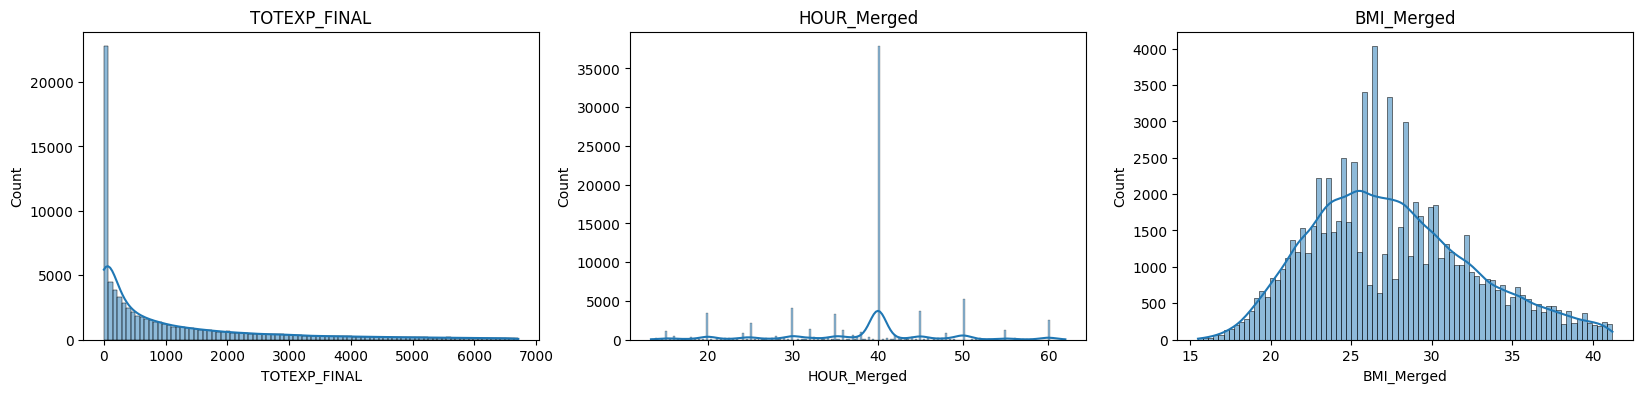

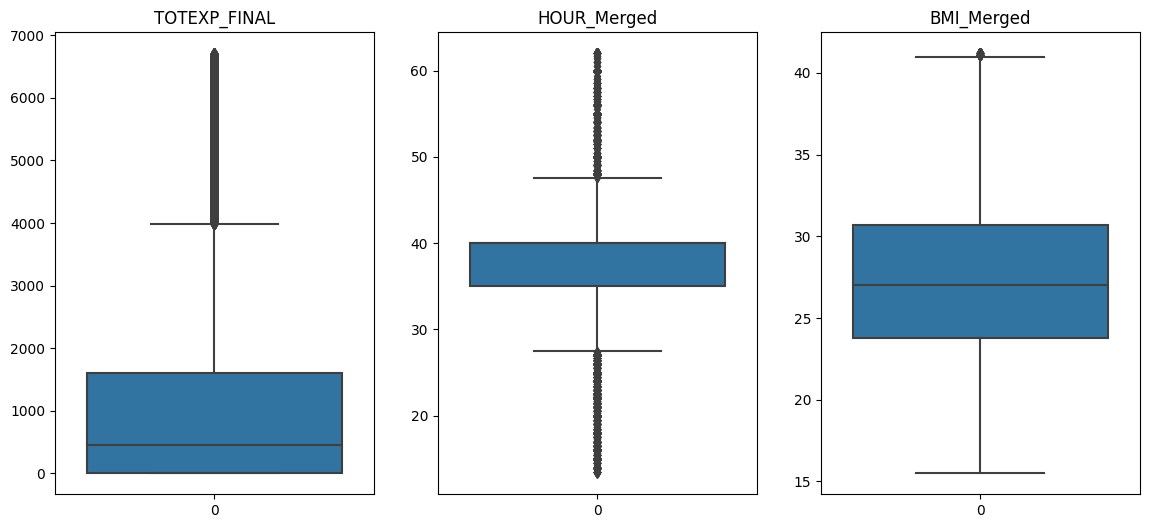

In [7]:
# see distribution after dropping outliers
f3, ax3 = plt.subplots(1, 3, figsize=(20, 4))
sns.histplot(final.TOTEXP_FINAL, kde=True, ax=ax3[0])
ax3[0].set_title('TOTEXP_FINAL')
sns.histplot(final.HOUR_Merged, kde=True, ax=ax3[1])
ax3[1].set_title('HOUR_Merged')
sns.histplot(final.BMI_Merged, kde=True, ax=ax3[2])
ax3[2].set_title('BMI_Merged')
plt.show()

f4, ax4 = plt.subplots(1, 3, figsize=(14, 6))
sns.boxplot(final.TOTEXP_FINAL, ax=ax4[0])
ax4[0].set_title('TOTEXP_FINAL')
sns.boxplot(final.HOUR_Merged, ax=ax4[1])
ax4[1].set_title('HOUR_Merged')
sns.boxplot(final.BMI_Merged, ax=ax4[2])
ax4[2].set_title('BMI_Merged');

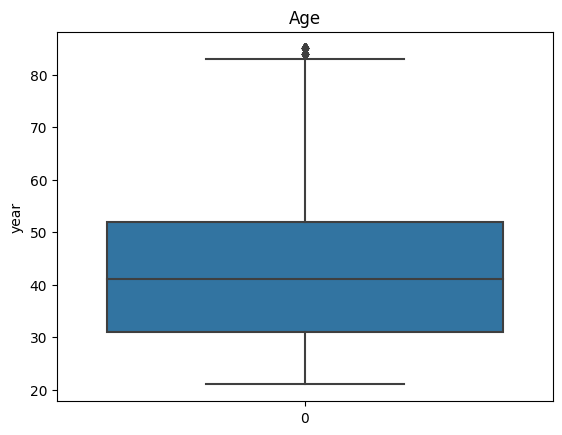

In [8]:
sns.boxplot(final.AGE_FINALX).set(title='Age', ylabel='year');

Summary of variables after dropping outliers, observe all variables are free from outliers, in addtion, observe age variable does not need further cleaning as does not contain outliers.

# Data Analysis & Results (EDA)

To carry out analysis around our research questions, we decided to first perform a multivariate linear regression on the variables in our interest. Followed by detail exploration on the relationships of medical expenditures with other variables one at a time.

## Regression results

In [9]:
# Run linear regression

y = final['TOTEXP_FINAL']
X = final[['RACEWX', 'RACEBX', 'RACEAX', 'RACETHX', 
          'REGION_NORTHEAST', 'REGION_MIDEAST', 'REGION_SOUTH', 
          'SMOKE', 'BMI_Merged', 'HOUR_Merged', 'AGE_FINALX']]

# Add a constant term to the independent variables
X = sm.add_constant(X)

# Fit the linear regression model
model = sm.OLS(y, X).fit()

# Print the model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           TOTEXP_FINAL   R-squared:                       0.090
Model:                            OLS   Adj. R-squared:                  0.090
Method:                 Least Squares   F-statistic:                     716.9
Date:                Sun, 19 Mar 2023   Prob (F-statistic):               0.00
Time:                        02:43:56   Log-Likelihood:            -6.9368e+05
No. Observations:               79794   AIC:                         1.387e+06
Df Residuals:                   79782   BIC:                         1.387e+06
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               74.3493     53.052  

Oberve all P-values for estimator coefficients are less than 0.05, implies statisticall signifacne for all.

C:\Users\jojo1\AppData\Local\Temp\ipykernel_35168\302478880.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = final.corr()


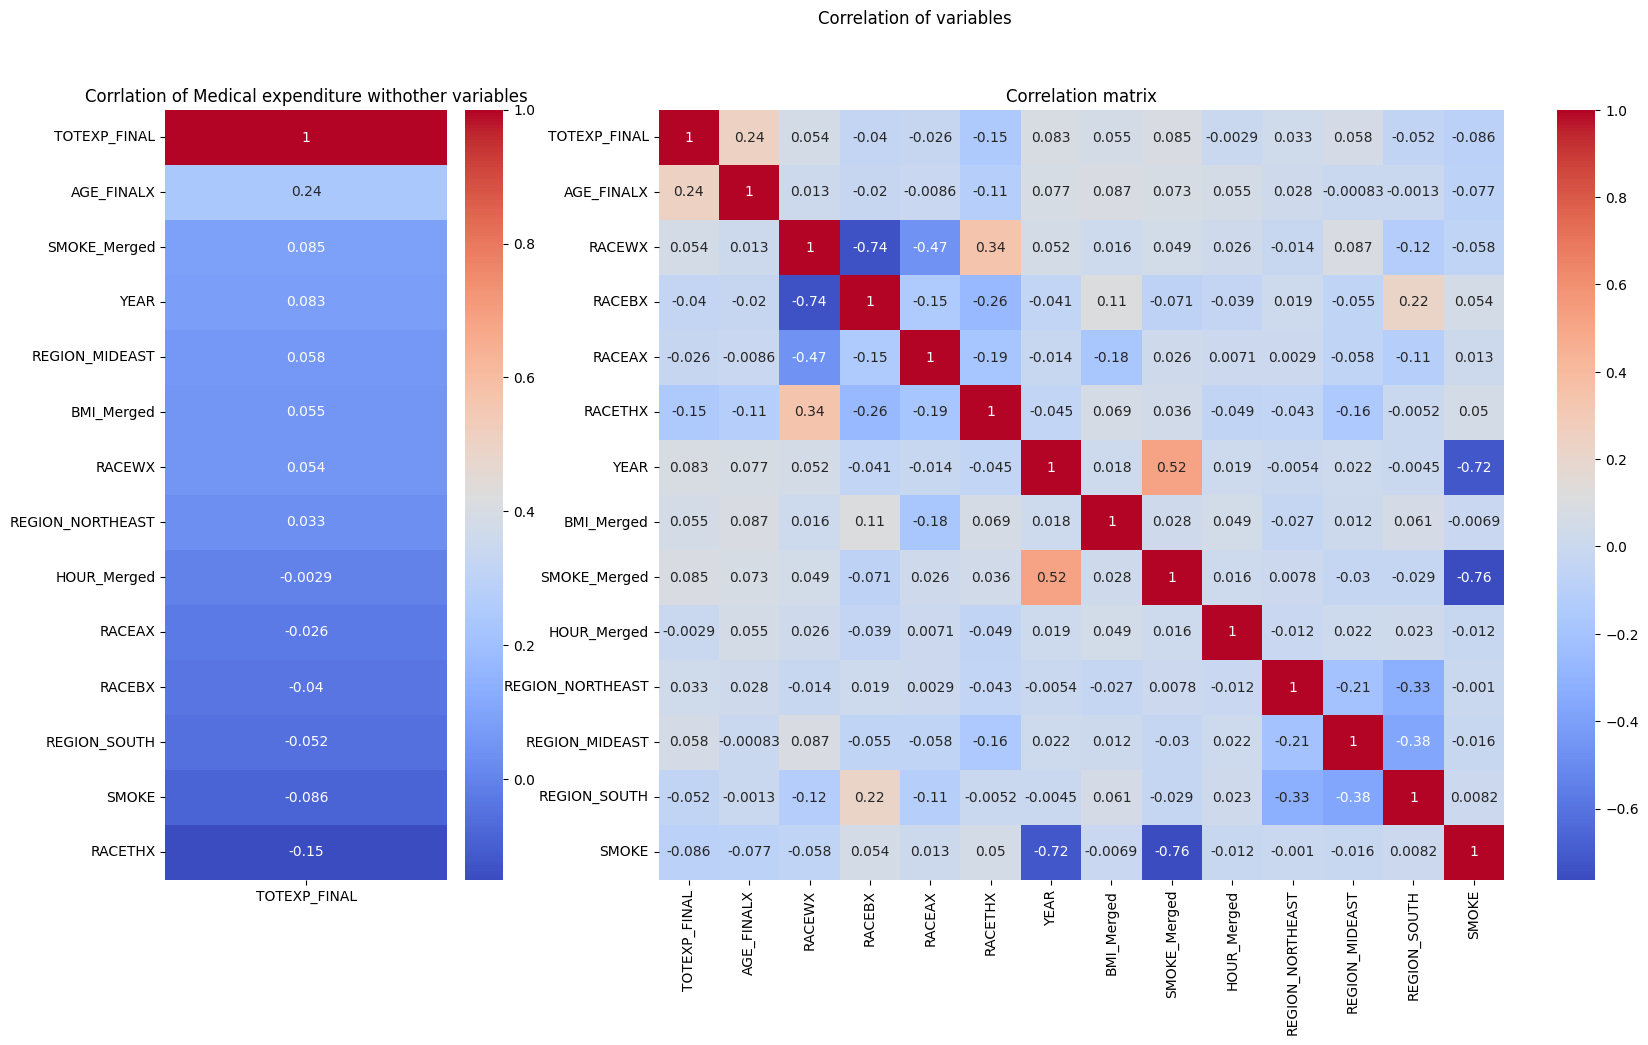

In [10]:
# covariance matrix
corr_matrix = final.corr()
f1, ax1 = plt.subplots(1, 2, figsize=(20, 10), gridspec_kw={'width_ratios': [1, 3]})
(sns.heatmap(corr_matrix.iloc[:, :1].sort_values(by='TOTEXP_FINAL', ascending=False), annot=True, cmap='coolwarm', ax=ax1[0])
 .set(title="Corrlation of Medical expenditure withother variables"))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm' ,ax=ax1[1]).set(title="Correlation matrix")
f1.suptitle('Correlation of variables')
plt.show()

Above are the correlation coefficient of variables in the regression, illustrates the linear relationship between variables, observe age have the highest correlation with expenditure of 0.24 among other variables.

## Age and Medical expenditure

[Text(0.5, 1.0, 'Distribution of Age')]

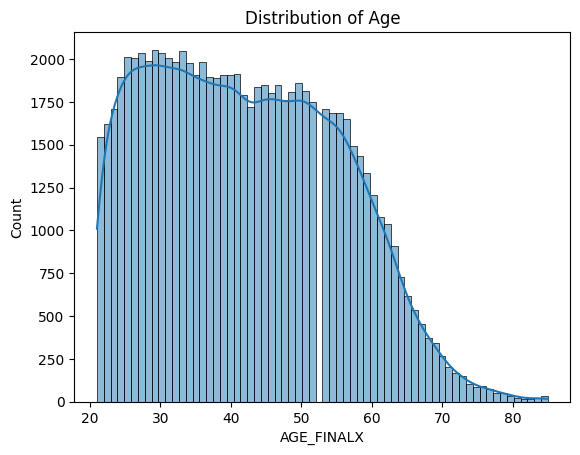

In [11]:
sns.histplot(final.AGE_FINALX, kde=True).set(title="Distribution of Age")

Above plot visualises the distribution of age

From our OLS estimator, observe variable AGE is statistially significant with value of 24.3225, implies keeping all else constant, our model estimates on average a 24.3225$ increase on medical expenditure with one additional year of age. 

## Medical expenditure overtime

[Text(0.5, 1.0, 'Medical expenditure overtime')]

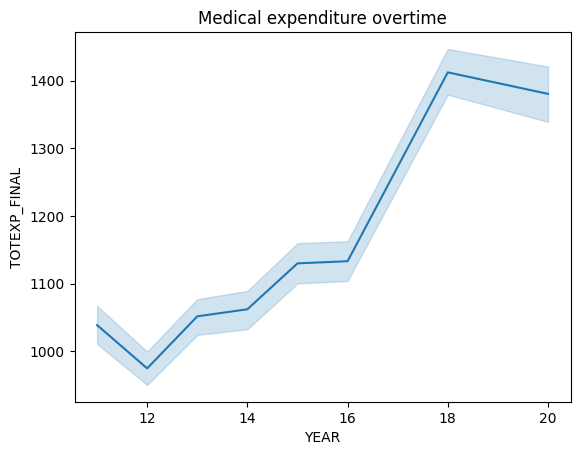

In [12]:
# time series on exp ,INFLATION ADJUSTED!
sns.lineplot(x='YEAR', y='TOTEXP_FINAL', data=final).set(title="Medical expenditure overtime")

A line plot is a great way to visualize changes in total medical expenditure over time because a line plot displays data points as individual marks along an axis, and connects them with lines to show the overall trend over time. We set the x-axis as YEAR, which is from 2011 to 2020, and the y-axis as Total medical expenditure. By looking at the line plot describing the total medical expenditure from 2011 to 2020, we can see the total medical expenditure is decreasing from 2011 to 2012, and keep increasing from 2012 to 2018, and slightly decreasing from 2018 to 2020. The overall trend of total medical expenditure from 2011 to 2020 increased. Because we already adjust the price inflation problem, we can conclude that the increase of total medical expenditure is caused by other factors. What features cause changes in total medical expenditure is the question we will discuss in the next step.

## BMI and Medical expenditure

[Text(0.5, 1.0, 'Distribution of BMI')]

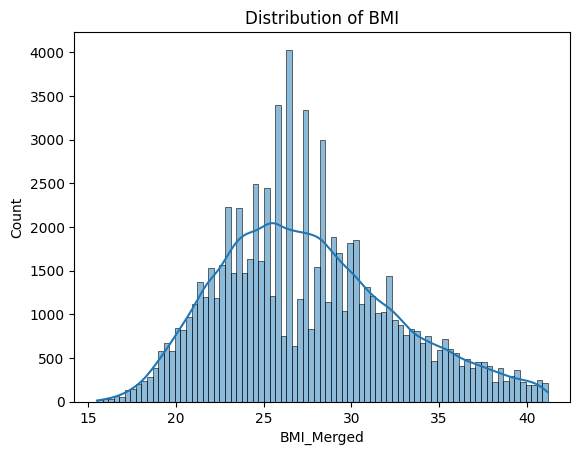

In [13]:
# distribution on BMI
sns.histplot(final.BMI_Merged, kde=True).set(title="Distribution of BMI")


We can see that the BMI values follow a slightly right-skewed normal distribution. We see a peak in the distribution towards the left side of the graph, with a tail extending towards the right side, indicating that there are relatively more individuals with BMI values ranging between 20 and 30 than those with BMI values lower than 20 and greater than 35. Thus, most people are normal and slightly overweight and less are underweight, obese and extremely obese. 

From the proportion plot, we can see the same trend more clearly where approximately the same proportion of people are normal and overweight. The proportions of people who are obese and extremely obese are relatively lower but still significantly higher than that of people who are overweight. 

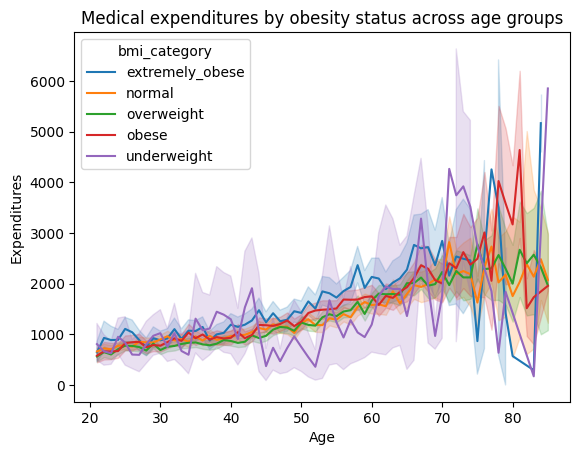

In [14]:
def bmi_range(bmi):
    if bmi < 18.5:
        return 'underweight'
    elif (bmi >= 18.5) & (bmi < 25):
        return 'normal'
    elif (bmi >= 25) & (bmi < 30):
        return 'overweight'
    elif (bmi >= 30) & (bmi < 35):
        return 'obese'
    else:
        return "extremely_obese"

final_bmi = final.assign(bmi_category = final.get('BMI_Merged').apply(bmi_range))

sns.lineplot(x = 'AGE_FINALX', y = 'TOTEXP_FINAL', hue = 'bmi_category', data = final_bmi).set(
    title = 'Medical expenditures by obesity status across age groups', xlabel = 'Age', ylabel = 'Expenditures');

The line plot above shows medical expenditures by obesity status revealed a general increase in costs across all groups by age. The fluctuations might be a result of medical insurance coverages but we see that extremely obese and underweight peoplehave higher medical expenditures across all age groups. Obese people follow a similar pattern but with slightly lower increases. Therefore, people with more extreme BMI values tend to have higher medical expenditures.

## Hours worked per week and Medical expenditure

[Text(0.5, 1.0, 'Distribution of hours worked per week')]

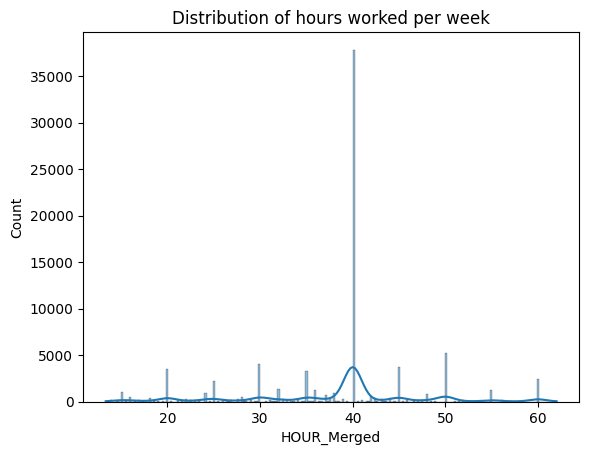

In [15]:
# distribution on hours worked
sns.histplot(final.HOUR_Merged, kde=True).set(title="Distribution of hours worked per week")

The graph shows the distribution of the column 'HOUR_Merged',which represents the working hour of people in a week. According to the graph we drew, people's working hours range from a low of 13.33 hours to a high of 62 hours, with a peak at 40 hours and an average working hours of 38.38 hours per week. From the graph, we observe that people's working hours tend to concentrate on 20, 30, 40, 50 and 60 hours. We speculate that this is because people prefer to round their working hours to the nearest 10 when filling in their information.

## Smoke and Medical expenditure

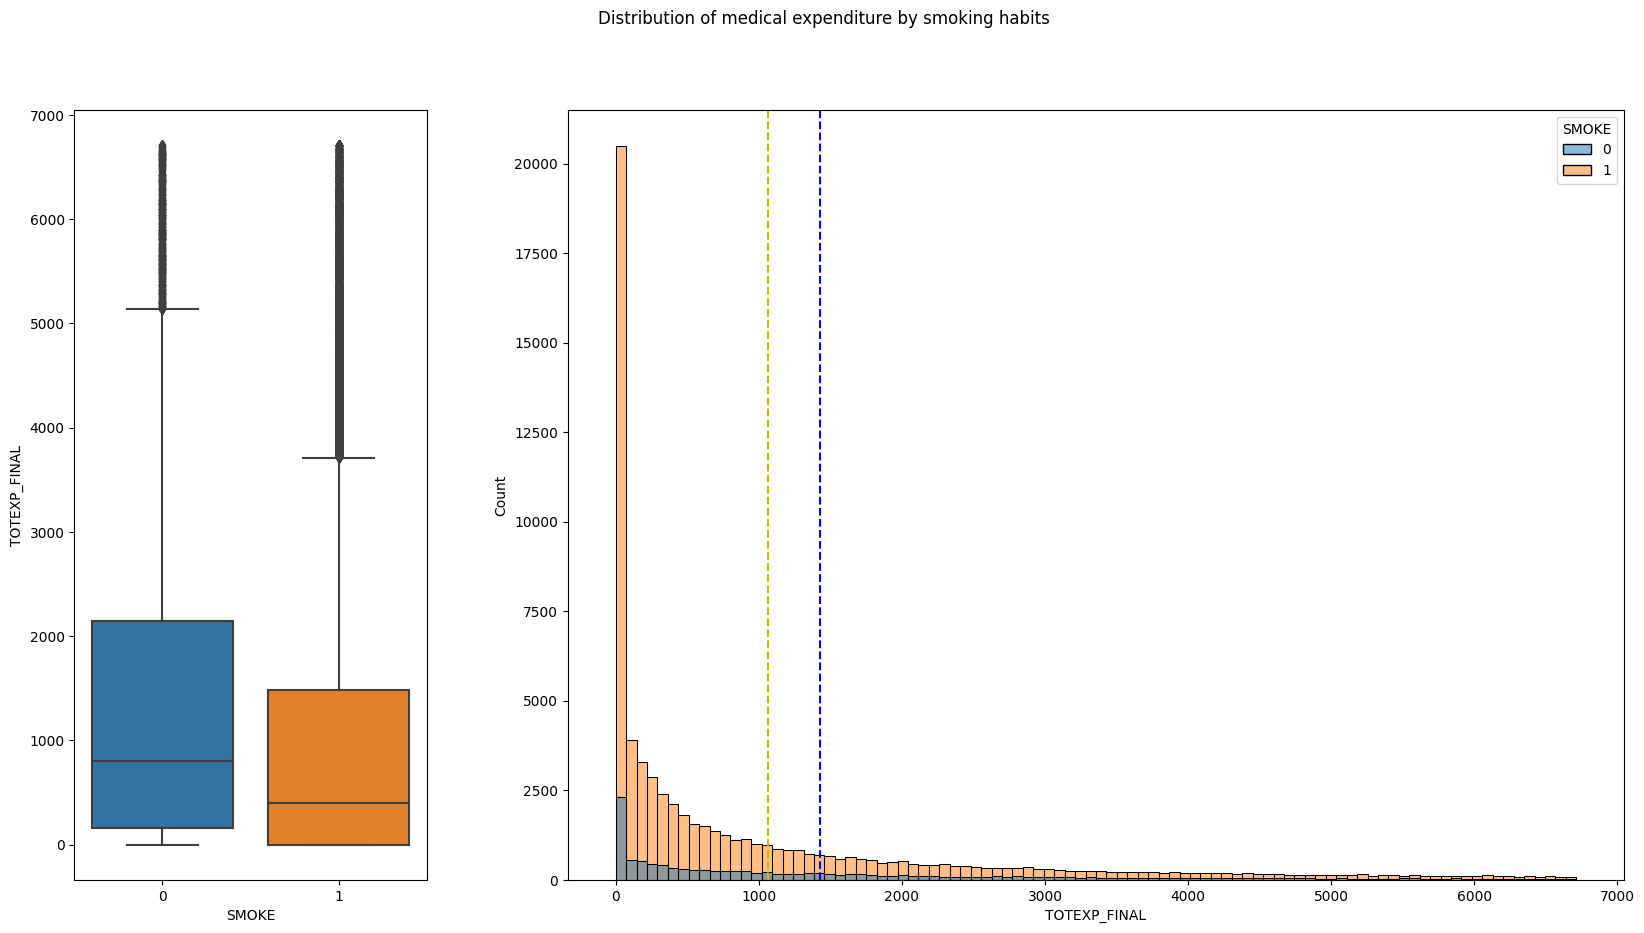

In [16]:
# distribution smoking and no smoking
f2, ax2 = plt.subplots(1, 2, figsize=(20, 10), gridspec_kw={'width_ratios': [1, 3]})
sns.boxplot(x='SMOKE', y='TOTEXP_FINAL', data=final, ax=ax2[0])
sns.histplot(hue='SMOKE', x='TOTEXP_FINAL', data=final[['TOTEXP_FINAL', 'SMOKE']], ax=ax2[1]);
ax2[1].axvline(final[final.SMOKE == 1]['TOTEXP_FINAL'].mean(), color='y', linestyle='--')
ax2[1].axvline(final[final.SMOKE == 0]['TOTEXP_FINAL'].mean(), color='b', linestyle='--')
f2.suptitle('Distribution of medical expenditure by smoking habits')
plt.show()

From this boxplot, we can see that the mean expenditure of people not smoke is about 800, but that of people smoke is about 500. In general, people not smoke will cost more expenditure and larger range of expenditure.

In our OLS regression result, we can see that the coeficient of smoke feature is -234.7292, implying that smoking has a negative relationship with total expenditure.

There are some limitations of our prediction: 1). smoker may sign with a higher medical insurance: medical insurance will cover the most of parts when smokers ill. 2). smoker may not seek medical care: they may underestimate their symptoms, and will not go to hospital until the condition becomes more servere. 3). smoker not really care their health: Besides smoking, they have other unhealth behaviours, but smokers do not care 4). smoker may die ealier: unhealth behaviours will push them to have a bad health condition, then they may die ealier Therefore, our result shows that smoking will cause less expenditure in general.

## Region and Medical expenditure

To perform analyzation on the relationship between region and medical expenditure, we first recall our regression estimators regarding region, and illustrate the distribution of expenditure differs by region.

Region coefficients: 
                   coefficients      p_values
REGION_NORTHEAST      60.687548  2.476504e-04
REGION_MIDEAST        50.239643  1.433704e-03
Dummy_region_west      0.000000           NaN
REGION_SOUTH        -103.556913  8.023678e-15


[Text(0.5, 1.0, 'Region Parameter Coefficients'),
 Text(0, 0.5, 'Dollars per year')]

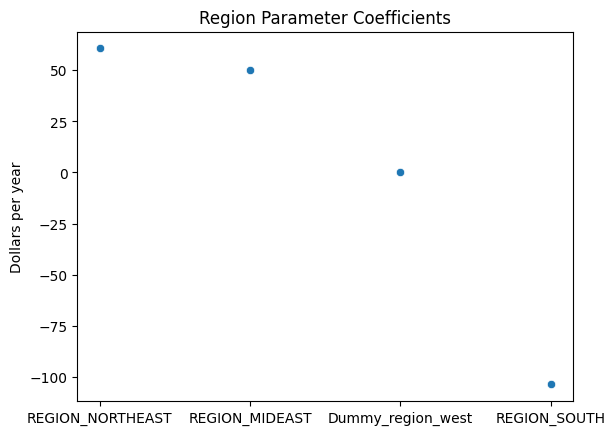

In [17]:
# Extract the coefficients for the variables of interest, insert our anchor variable
region_coeffs = model.params[['REGION_NORTHEAST', 'REGION_MIDEAST', 'REGION_SOUTH']]
region_pvals = model.pvalues[['REGION_NORTHEAST', 'REGION_MIDEAST', 'REGION_SOUTH']]
region_coeffs['Dummy_region_west'] = 0
region_pvals['Dummy_region_west'] = np.nan
region_comb = pd.concat([region_coeffs, region_pvals], axis=1)
region_comb = region_comb.rename(columns={0 : 'coefficients', 1 : 'p_values'})
# Print the coefficients
print(f'Region coefficients: \n{region_comb.sort_values("coefficients", ascending=False)}')
sns.scatterplot(data=region_coeffs.sort_values(ascending=False)).set(title='Region Parameter Coefficients', ylabel='Dollars per year')

Dot plot showing estimator coefficients for all dummy region variables in ascending order

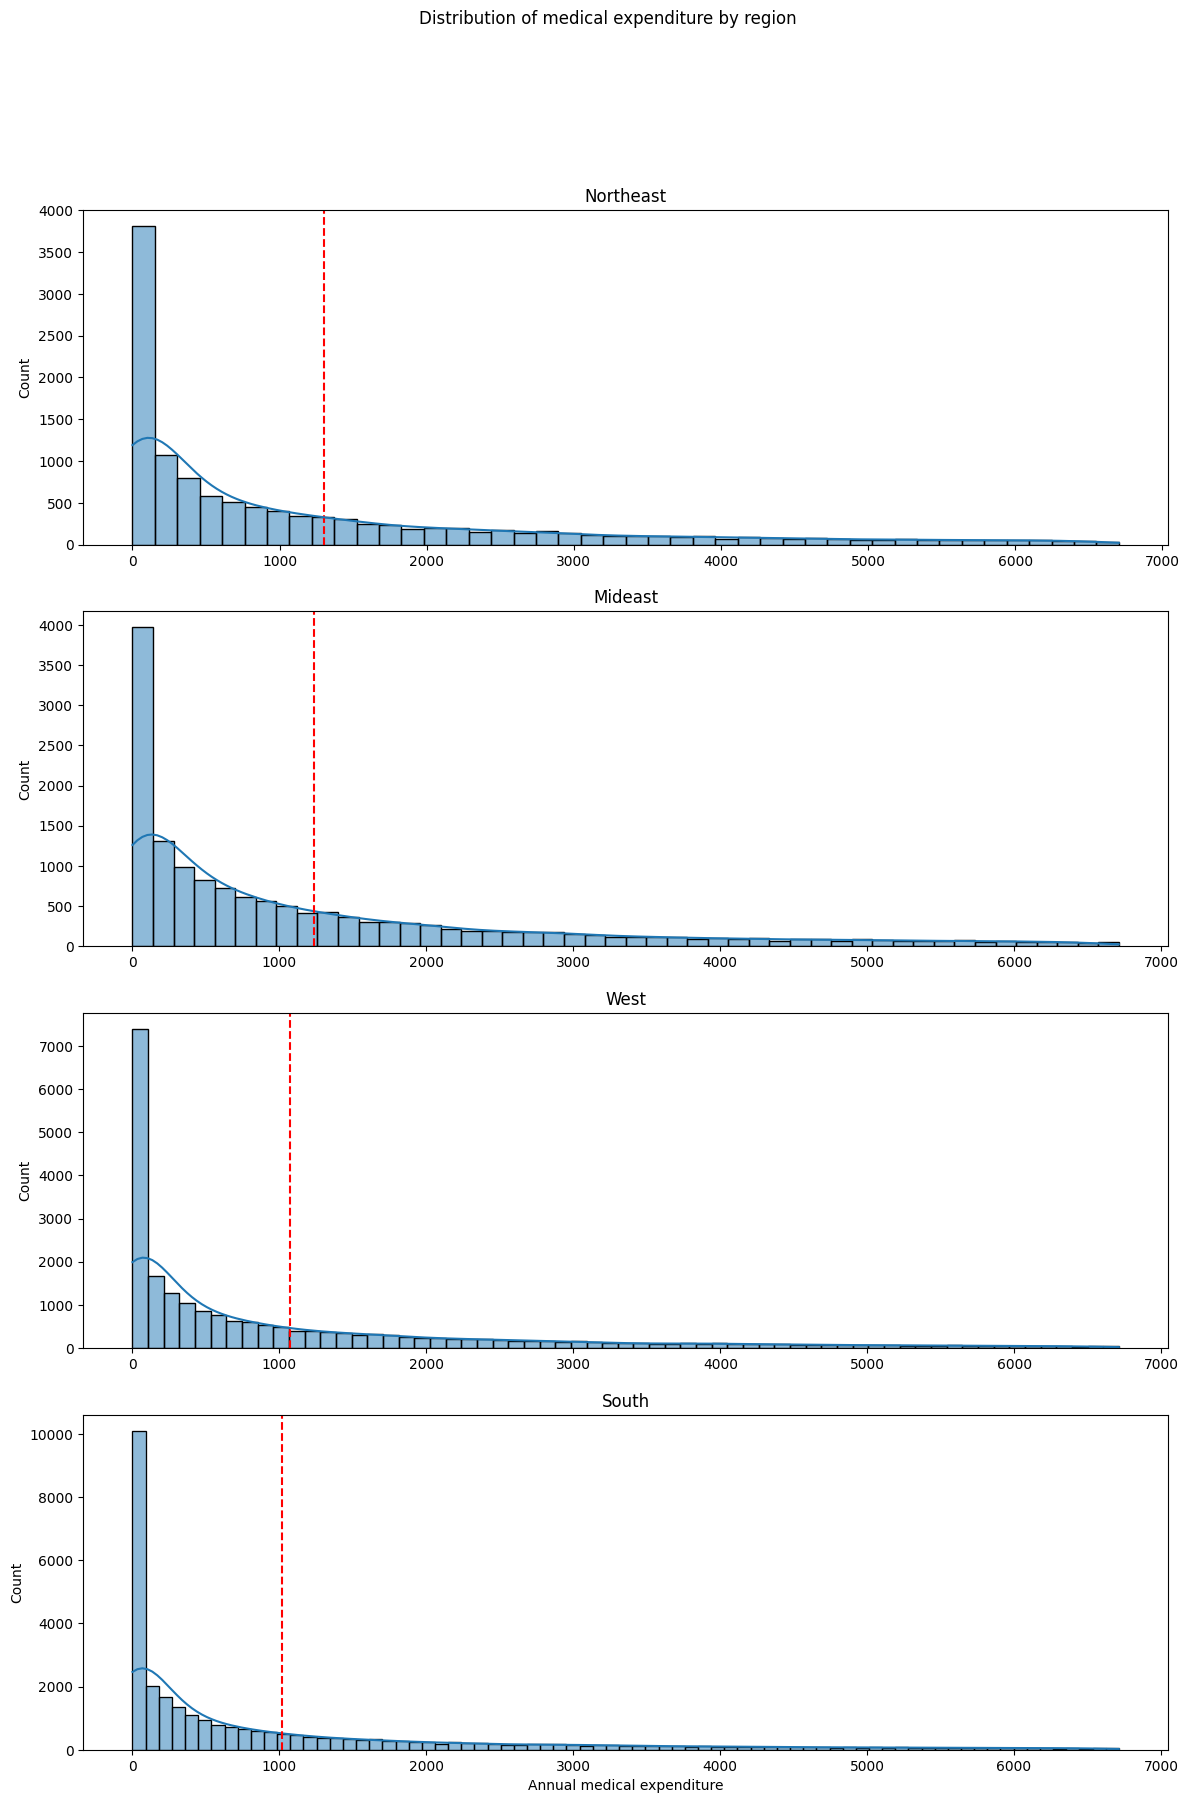

In [18]:
# f6, ax6 = plt.subplots(1, 4, figsize=(20, 20))
# f6.suptitle('Variability of medical expenditure by region')
# sns.boxplot(y='TOTEXP_FINAL', data=final[final.REGION_MIDEAST == 1], ax=ax6[0]).set(ylabel = 'Annual medical expenditure', 
#                                                                                     title = 'Mideast')
# sns.boxplot(y='TOTEXP_FINAL', data=final[final.REGION_NORTHEAST == 1], ax=ax6[1]).set(ylabel = '', title = 'Northeast')
# sns.boxplot(y='TOTEXP_FINAL', data=final[(final.REGION_NORTHEAST == 0) &
#                                          (final.REGION_MIDEAST == 0) &
#                                          (final.REGION_SOUTH == 0)], ax=ax6[2]).set(ylabel = '', title = 'West')
# sns.boxplot(y='TOTEXP_FINAL', data=final[final.REGION_SOUTH == 1], ax=ax6[3]).set(ylabel = '', title = 'South')

# plt.show()

f7, ax7 = plt.subplots(4, 1, figsize=(14, 20))
f7.suptitle('Distribution of medical expenditure by region')
sns.histplot(x='TOTEXP_FINAL', data=final[final.REGION_MIDEAST == 1], kde=True, ax=ax7[1]).set(xlabel='', title = 'Mideast')
ax7[0].axvline(final[final.REGION_MIDEAST == 1]['TOTEXP_FINAL'].mean(), color='r', linestyle='--')

sns.histplot(x='TOTEXP_FINAL', data=final[final.REGION_NORTHEAST == 1], kde=True, ax=ax7[0]).set(xlabel='', title = 'Northeast')
ax7[1].axvline(final[final.REGION_NORTHEAST == 1]['TOTEXP_FINAL'].mean(), color='r', linestyle='--')

sns.histplot(x='TOTEXP_FINAL', data=final[(final.REGION_NORTHEAST == 0) &
                                          (final.REGION_MIDEAST == 0) &
                                          (final.REGION_SOUTH == 0)], kde=True ,ax=ax7[2]).set(xlabel='', title = 'West')
ax7[2].axvline(final[(final.REGION_NORTHEAST == 0) &
                        (final.REGION_MIDEAST == 0) &
                        (final.REGION_SOUTH == 0)]['TOTEXP_FINAL'].mean(), color='r', linestyle='--')

sns.histplot(x='TOTEXP_FINAL', data=final[final.REGION_SOUTH == 1], kde=True ,ax=ax7[3]).set(xlabel='Annual medical expenditure', 
                                                                                             title = 'South')
ax7[3].axvline(final[final.REGION_SOUTH == 1]['TOTEXP_FINAL'].mean(), color='r', linestyle='--')



plt.show()


Box plot illustrating variability of annual medical expenditure catigorized by region, red line indicates mean of selected samples

### Conclusion

Our analysis suggests that, on average, individuals live in the Northeast region of the nation have the highest medical spending - 61 dollar more per year than those who live in the west, where as those who lives in south have the lowest average medical spending - 104 less then those who live in the west.

## Race and Medical expenditure

Recall race estimators first

Race coefficients: 
         coefficients      p_values
RACEWX     253.551743  3.687823e-14
RACEBX     -77.976454  2.378447e-02
RACEAX     -78.406554  3.005372e-02
RACETHX   -532.976316  0.000000e+00


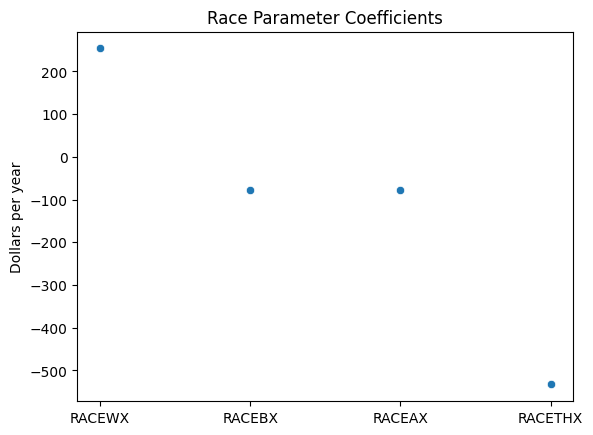

In [19]:
# Extract the coefficients for the variables of interest
race_coeffs = model.params[['RACEWX', 'RACEBX', 'RACEAX', 'RACETHX']]
race_pvals = model.pvalues[['RACEWX', 'RACEBX', 'RACEAX', 'RACETHX']]
race_comb = pd.concat([race_coeffs, race_pvals], axis=1)
race_comb = race_comb.rename(columns={0 : 'coefficients', 1 : 'p_values'})
# Print the coefficients, insert our anchor variab
print(f'Race coefficients: \n{race_comb.sort_values("coefficients", ascending=False)}')
sns.scatterplot(data=race_coeffs.sort_values(ascending=False)).set(title='Race Parameter Coefficients', ylabel='Dollars per year');

Dot plot showing estimator coefficients for all dummy racial variables in ascending order

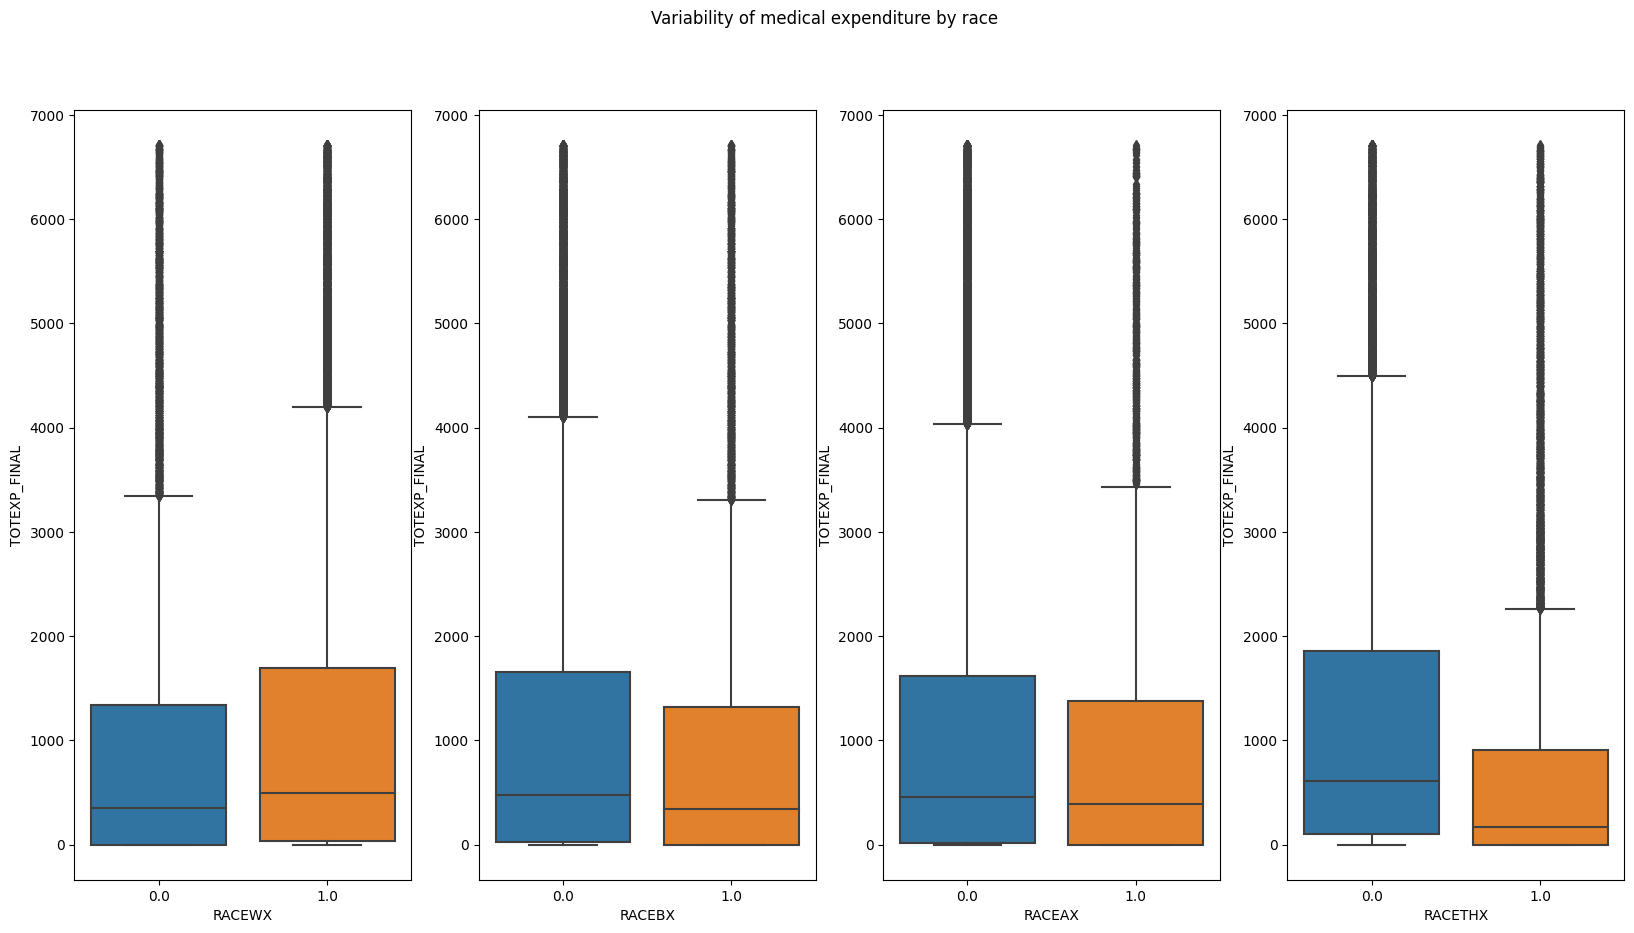

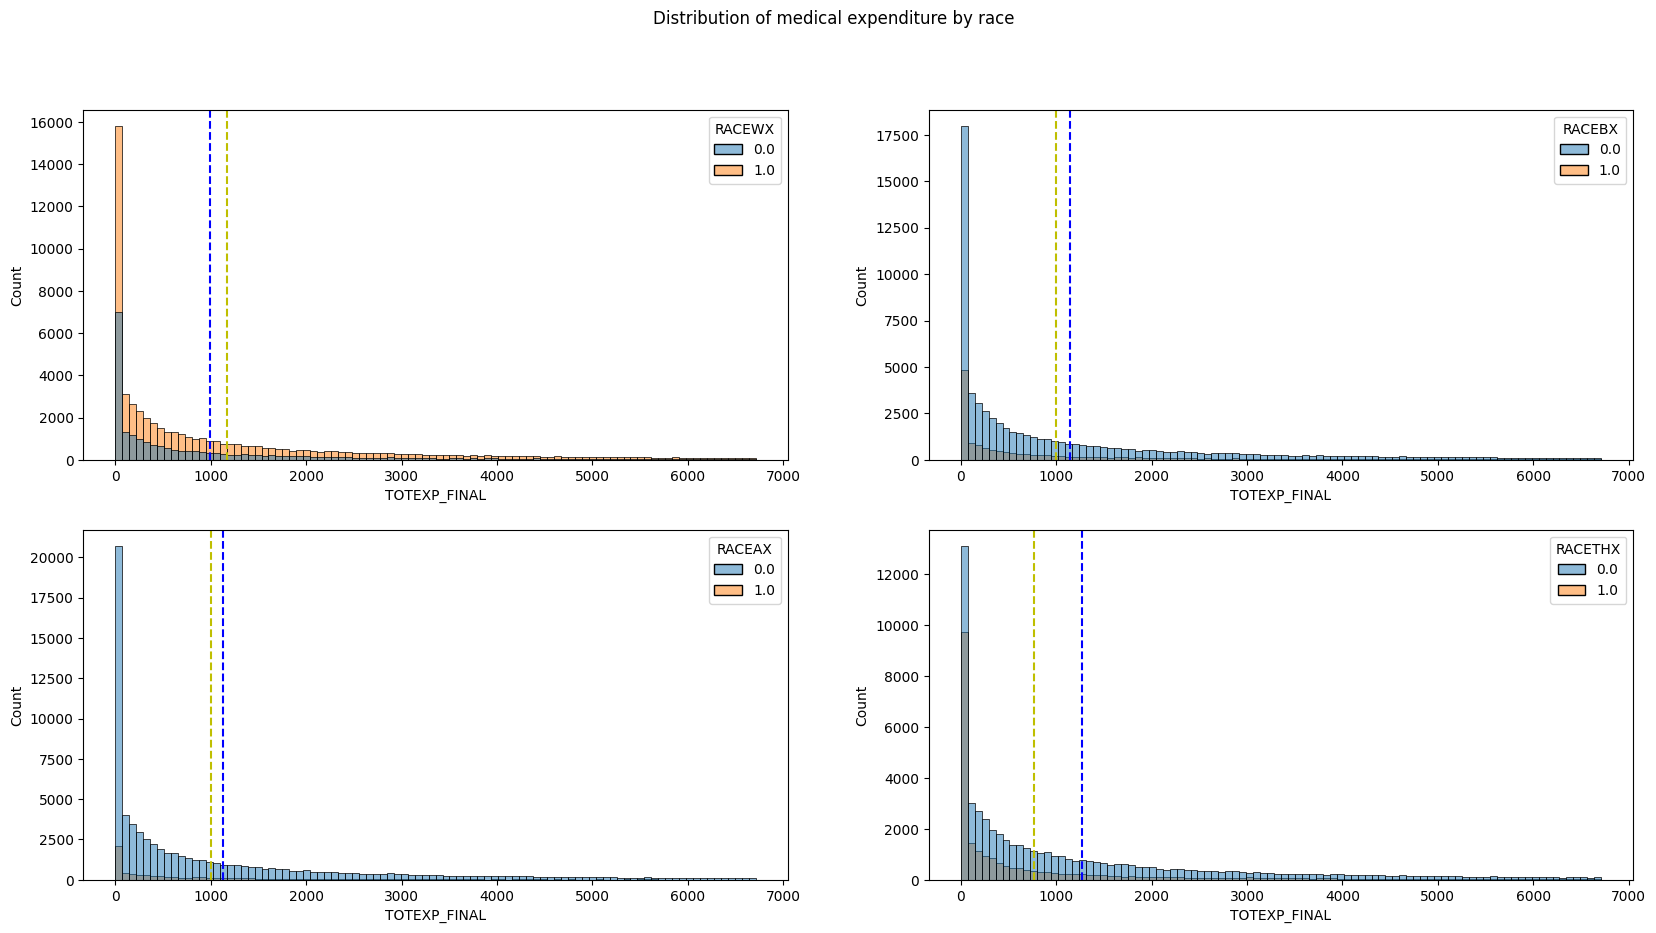

In [20]:
f5, ax5 = plt.subplots(1, 4, figsize=(20, 10))
f5.suptitle('Variability of medical expenditure by race')
sns.boxplot(x='RACEWX', y='TOTEXP_FINAL', data=final, ax=ax5[0])
sns.boxplot(x='RACEBX', y='TOTEXP_FINAL', data=final, ax=ax5[1])
sns.boxplot(x='RACEAX', y='TOTEXP_FINAL', data=final, ax=ax5[2])
sns.boxplot(x='RACETHX', y='TOTEXP_FINAL', data=final, ax=ax5[3])
plt.show()

f7, ax7 = plt.subplots(2, 2, figsize=(20, 10))
f7.suptitle('Distribution of medical expenditure by race')
sns.histplot(x='TOTEXP_FINAL', data=final, hue = 'RACEWX',ax=ax7[0][0])
ax7[0][0].axvline(final[final.RACEWX == 1]['TOTEXP_FINAL'].mean(), color='y', linestyle='--')
ax7[0][0].axvline(final[final.RACEWX != 1]['TOTEXP_FINAL'].mean(), color='b', linestyle='--')
sns.histplot(x='TOTEXP_FINAL', data=final, hue = 'RACEBX',ax=ax7[0][1])
ax7[0][1].axvline(final[final.RACEBX == 1]['TOTEXP_FINAL'].mean(), color='y', linestyle='--')
ax7[0][1].axvline(final[final.RACEBX != 1]['TOTEXP_FINAL'].mean(), color='b', linestyle='--')
sns.histplot(x='TOTEXP_FINAL', data=final, hue = 'RACEAX',ax=ax7[1][0])
ax7[1][0].axvline(final[final.RACEAX == 1]['TOTEXP_FINAL'].mean(), color='y', linestyle='--')
ax7[1][0].axvline(final[final.RACEAX != 1]['TOTEXP_FINAL'].mean(), color='b', linestyle='--')
sns.histplot(x='TOTEXP_FINAL', data=final, hue = 'RACETHX',ax=ax7[1][1])
ax7[1][1].axvline(final[final.RACETHX == 1]['TOTEXP_FINAL'].mean(), color='y', linestyle='--')
ax7[1][1].axvline(final[final.RACETHX != 1]['TOTEXP_FINAL'].mean(), color='b', linestyle='--')
plt.show()

Above plots illustrates the variability of medical expenditure between individuals that hold the specified racial identity and individuals that does not hold the racial identity categorized by racial identities. Yellow line in histogram indicates average annual medical spending for those identify as target race while blue line idicate that of those who does not identify as target race

Observe only those who identify racially as white have an average annual medical spending larger than those who does not identify as White among other racial categories. All coefficients are statistically significant according to our model. Also, among the estimator coefficients, individuals who identify as Latino/Hispanic spend significantly less than others identify as other races, with a astonishing prediction of 532.97$ less per year than those who does not identify as Hispanic. A possible explaination we have on those two observations is that those who identify as Latino/Hispanic on average have lower earnings which causes them to spend less on medical services per year. On the other hand, those who identify as White among other racial categories have on average a higher annual wage amount others, which cause them to spend more on medical services per year.

### Conclusion

Our analysis suggests that, on average, individuals who identify as white have higher medical spending compared to those who do not identify as white. In contrast, individuals identifying with all other races have lower medical expenditures compared to those who does not identify as that specific race.